In [33]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy.linalg import eigvalsh, qr

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

from time import time
from mpire import WorkerPool
from scipy.stats import sem
import os

import koala

from koala.voronization import generate_point_array, generate_lattice
from koala.graph_utils import vertex_neighbours, clockwise_edges_about, clockwise_about, get_edge_vectors
from koala.plotting import plot_edges
from koala.pointsets import generate_bluenoise,  generate_random
from koala.graph_color import color_lattice
from koala.lattice import Lattice
from koala.weaire_thorpe import vertices_to_triangles
from koala.example_graphs import generate_honeycomb
from koala.flux_finder import find_flux_sector, fluxes_from_bonds, fluxes_to_labels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


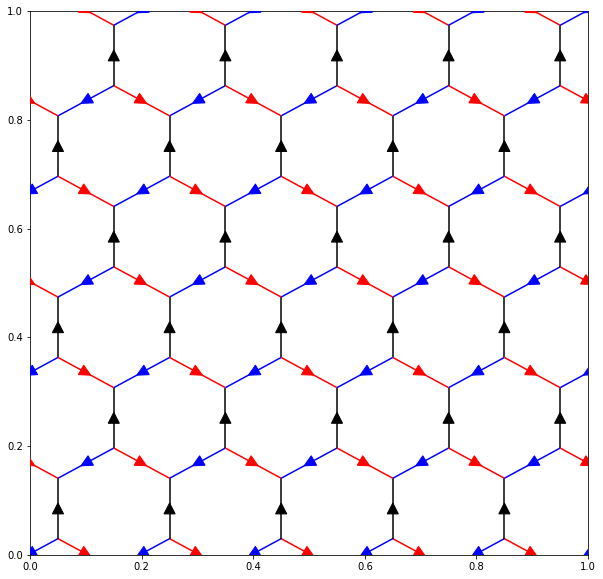

In [59]:


# create approx n^2 points
n = 5 # default to small lattice to reduce computation time
#n = 15 #uncomment to do a more reasonably size lattice
    
fig, ax = plt.subplots()  

# points =  generate_bluenoise(k = 100, nx = n, ny = n)
# lattice = generate_lattice(points)
# coloring = color_lattice(lattice)

lattice, coloring = generate_honeycomb(n, return_coloring = True)

plot_edges(lattice, directions = True, labels = coloring);

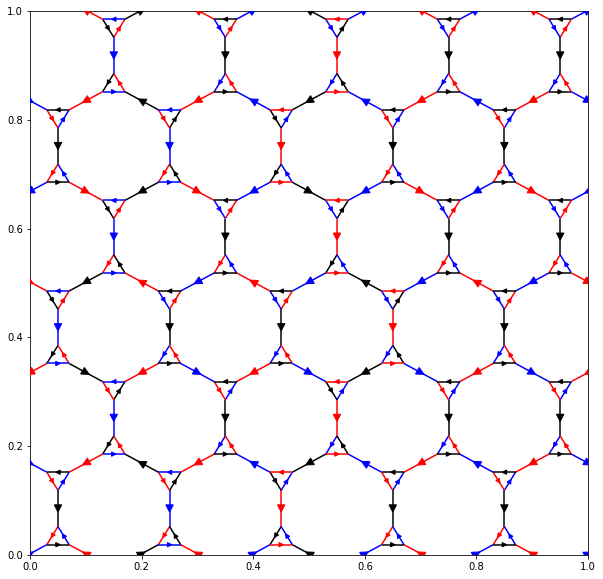

In [67]:
def generate_triangulated_honeycomb(n):
    lattice, coloring = generate_honeycomb(n, return_coloring = True)
    triangle_lattice = vertices_to_triangles(lattice, coloring);
    triangle_coloring = color_lattice(triangle_lattice)
    return triangle_lattice, triangle_coloring
    

triangle_lattice, triangle_coloring = generate_triangulated_honeycomb(n)

fig, ax = plt.subplots()
plot_edges(triangle_lattice, directions = True, labels = triangle_coloring);

In [62]:
triangle_lattice.n_plaquettes

90

In [31]:
def construct_hamiltonian(lattice: Lattice, edge_colouring: np.ndarray, ujk: np.ndarray, J_values: np.ndarray, K:np.float32 =0.2):
    """construct the A matrix that the hamiltonian uses
    :param lattice: system to construct the matrix on
    :type lattice: Lattice
    :param edge_colouring: colouring for the edges must be a set of ±1 values
    :type edge_colouring: np.ndarray
    :param ujk: bond signs
    :type ujk: np.ndarray
    :param J_values: j values
    :type J_values: np.ndarray
    :param K: three spin field strength
    :type K: np.float32
    :return: the A matrix
    :rtype: np.ndarray
    """
    edge_type_list = J_values[edge_colouring]
    bond_values = 2*edge_type_list*ujk

    ham = np.zeros((lattice.n_vertices, lattice.n_vertices))
    ham[lattice.edges.indices[:,1], lattice.edges.indices[:,0]] = bond_values
    ham[lattice.edges.indices[:,0], lattice.edges.indices[:,1]] = -bond_values

    K_ham = np.zeros((lattice.n_vertices, lattice.n_vertices))
    K_ham[lattice.edges.indices[:,1], lattice.edges.indices[:,0]] = ujk
    K_ham[lattice.edges.indices[:,0], lattice.edges.indices[:,1]] = -ujk
    K_ham = K_ham @ K_ham
    K_ham *= 2*K
    K_ham = np.tril(-1*K_ham) + np.triu(K_ham)
    np.fill_diagonal(K_ham, 0)
    
    return 1.0j*(ham - K_ham)

In [ ]:
def DOS_from_random_vortices(worker_idx, lattice, colouring, vortex_density, field_strength):
    np.random.seed(worker_idx + (os.getpid() * int(time())) % 123456789)
    vortices = np.random.choice([1,-1], p = [1-vortex_density, vortex_density], size = lattice.n_plaquettes)
    ujk = find_flux_sector(lattice, vortices)
    
    Ajk = construct_hamiltonian(lattice, colouring,ujk, np.array([1,1,1]), field_strength)
    energies = np.abs(np.linalg.eigvalsh(Ajk))
    
    H, edges = np.histogram(energies, bins = bins, density=True)
    return H

def parallelise(n_samples, function, n_jobs, chunk_size, args = [], kwargs = {}):
    """
    n_samples: number of times to sample the function
    function: function to call on shared_data
    n_jobs: how many jobs to use, try around the number of CPUs
    *args **kwargs: the rest gets passed directly to function, i.e function(*args, **kwargs)
    """
    print(f"Starting computation over {n_samples} points with {n_jobs} parallel procesess.")
    def computation(shared_data, indices):
        args, kwargs = shared_data
        return np.array([function(i, *args, **kwargs) for i in indices])

    t0 = time()
    with WorkerPool(n_jobs = n_jobs, shared_objects = (args, kwargs)) as pool: 
        data = pool.map(computation, np.arange(n_samples), progress_bar = True, chunk_size=chunk_size).T
        
    dt = time() - t0
    print(f'That tooks {dt:.2f} seconds')

    return data

nsamples = 50_000
nbins = 100
n_jobs = None
chunk_size = 20 #how many samples each worker does in a chunk, set it too large and the graph will update slowly

bins = np.logspace(-2,0,num = nbins)
field_strength = 0.0
vortex_density = 0.5
L = 10


lattice, coloring = generate_triangulated_honeycomb(L)
# lattice, coloring = generate_honeycomb(L, return_coloring = True)

starting_ujk = find_flux_sector(lattice)

data = parallelise(nsamples, DOS_from_random_vortices, n_jobs, chunk_size, args = (lattice, coloring, vortex_density, field_strength))

Starting computation over 50000 points with None parallel procesess.


  0%|                                                                                                         …

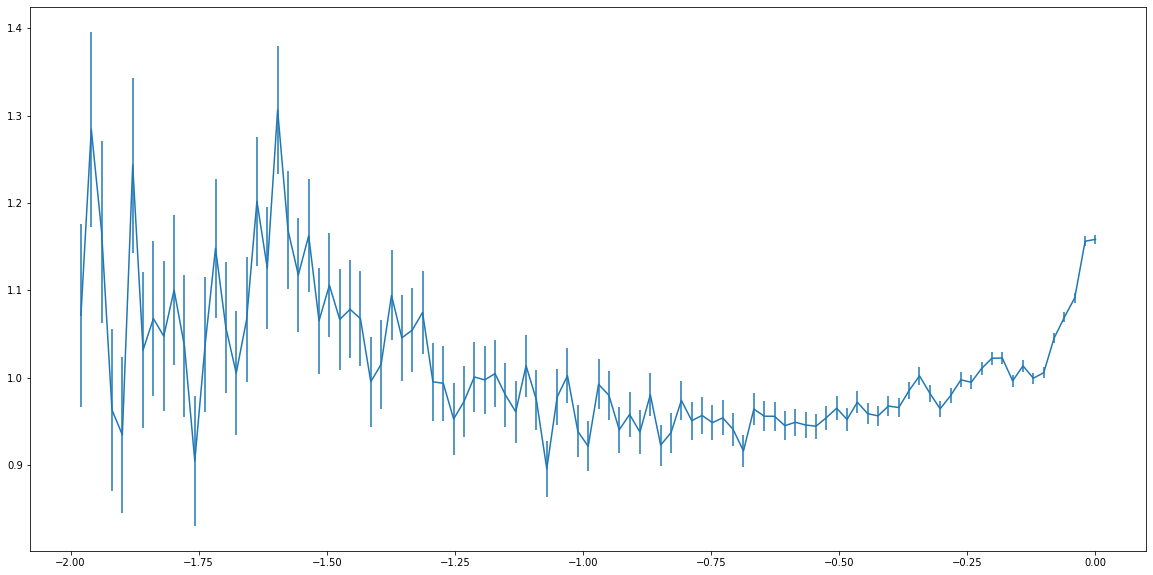

In [70]:
H_means = np.mean(data, axis=-1)
H_std = sem(data, axis=-1)

plt.figure(figsize=(20,10))

#for H_i in H_accumulator[:500]:
#    plt.semilogx(edges[1:], H_i, '-', alpha=0.2)
plt.errorbar(np.log10(bins[1:]), H_means, H_std, fmt='-')
#plt.semilogx(edges[1:], H_means, '-')
#plt.xlim([-2,0])

if "saved_data" not in globals():
    saved_data = {}

saved_data[L] = [H_means, H_std]

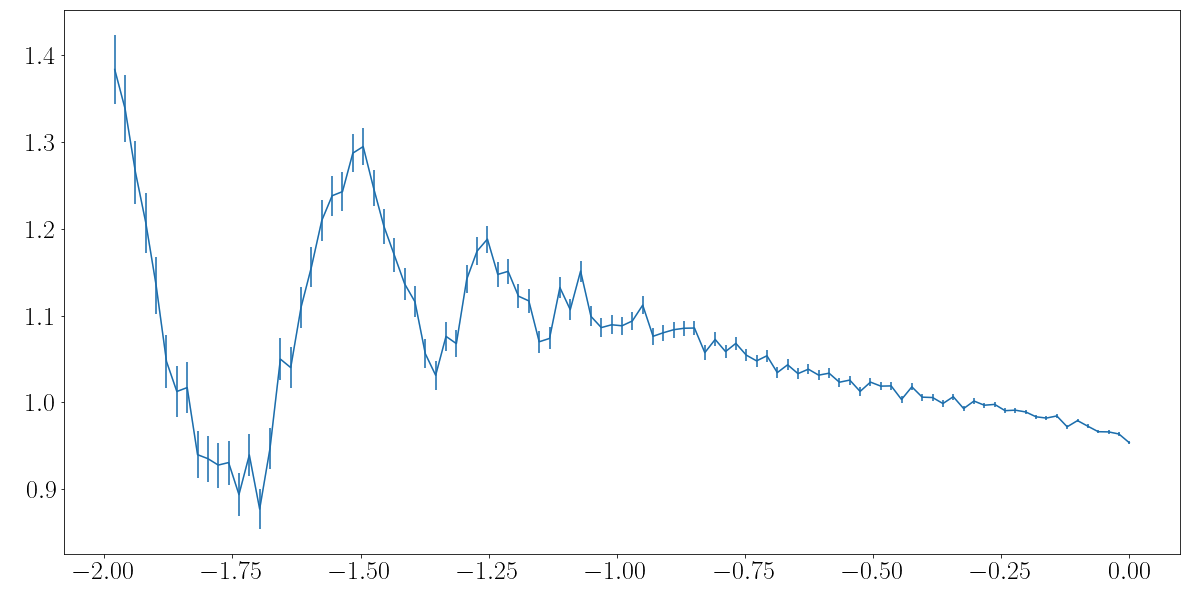

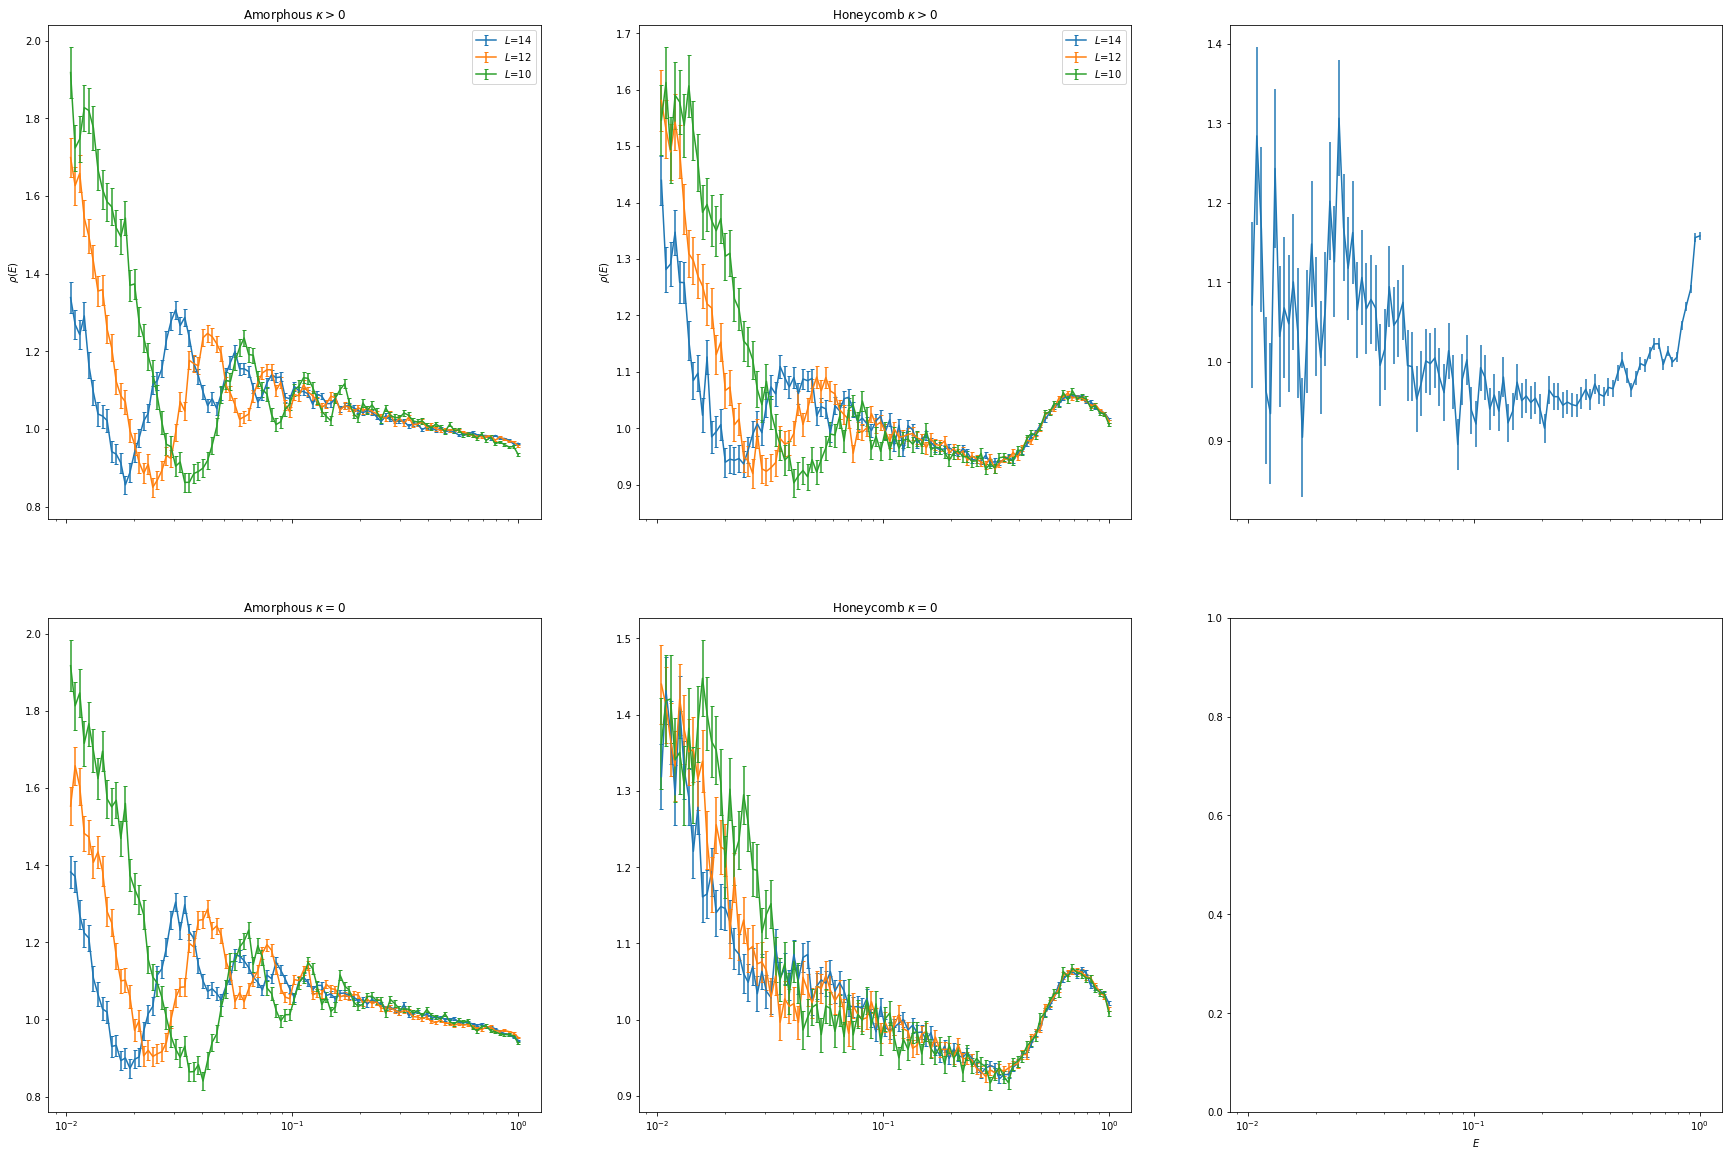

In [73]:
am_saved_data_field = np.load('dos_oscillation_data/dos_oscillations_am_field.npy', allow_pickle=True).tolist()
hlm_saved_data_field = np.load('dos_oscillation_data/dos_oscillations_hlm_field.npy', allow_pickle=True).tolist()
am_saved_data_nofield = np.load('dos_oscillation_data/dos_oscillations_am_nofield.npy', allow_pickle=True).tolist()
hlm_saved_data_nofield = np.load('dos_oscillation_data/dos_oscillations_hlm_nofield.npy', allow_pickle=True).tolist()


import matplotlib
# matplotlib.rcParams.update({'font.size': 26, 'text.usetex': False, 'font.family': 'serif', 'font.serif': ['Computer Modern']})


fig, ax = plt.subplots(2,ncols = 3,sharex=True)



fig.set_figheight(20)
fig.set_figwidth(30)

error_args = {'capsize': 2}


nbins=100
bins = np.logspace(-2,0,num = nbins)

ax[0][2].errorbar(bins[1:], H_means, H_std, fmt='-')

ax[0][0].errorbar(bins[1:], *am_saved_data_field[14], fmt='-', label='$L$=$14$', **error_args)
ax[0][0].errorbar(bins[1:], *am_saved_data_field[12], fmt='-', label='$L$=$12$', **error_args)
ax[0][0].errorbar(bins[1:], *am_saved_data_field[10], fmt='-', label='$L$=$10$', **error_args)
ax[0][0].set_title(r"Amorphous $\kappa>0$")

ax[0][1].errorbar(bins[1:], *hlm_saved_data_field[14], fmt='-', label='$L$=$14$', **error_args)
ax[0][1].errorbar(bins[1:], *hlm_saved_data_field[12], fmt='-', label='$L$=$12$', **error_args)
ax[0][1].errorbar(bins[1:], *hlm_saved_data_field[10], fmt='-', label='$L$=$10$', **error_args)
ax[0][1].set_title(r"Honeycomb $\kappa>0$")

ax[1][0].errorbar(bins[1:], *am_saved_data_nofield[14], fmt='-', label='$L$=$14$', **error_args)
ax[1][0].errorbar(bins[1:], *am_saved_data_nofield[12], fmt='-', label='$L$=$12$', **error_args)
ax[1][0].errorbar(bins[1:], *am_saved_data_nofield[10], fmt='-', label='$L$=$10$', **error_args)
ax[1][0].set_title(r"Amorphous $\kappa=0$")

ax[1][1].errorbar(bins[1:], *hlm_saved_data_nofield[14], fmt='-', label='$L$=$14$', **error_args)
ax[1][1].errorbar(bins[1:], *hlm_saved_data_nofield[12], fmt='-', label='$L$=$12$', **error_args)
ax[1][1].errorbar(bins[1:], *hlm_saved_data_nofield[10], fmt='-', label='$L$=$10$', **error_args)
ax[1][1].set_title(r"Honeycomb $\kappa=0$")

plt.xlabel('$E$')

ax[0][0].set_ylabel(r'$\rho(E)$')
ax[0][1].set_ylabel(r'$\rho(E)$')

plt.xscale('log')
ax[0][0].legend()
ax[0][1].legend()

plt.savefig('honeycomb_extended_dos.png')